AMPLITUDE STATISTICS FOR DIFFERENT NOISE TYPES

Processing blue noise...
  Mean amplitude: -0.0000
  Std amplitude:  0.0016
  Min amplitude:  -0.0037
  Max amplitude:  0.0037
  Total samples:  5400

Processing brownian noise...
  Mean amplitude: -0.0093
  Std amplitude:  1.3100
  Min amplitude:  -5.2811
  Max amplitude:  5.5338
  Total samples:  5400

Processing mmc noise...
  Mean amplitude: -0.0020
  Std amplitude:  0.8272
  Min amplitude:  -2.6577
  Max amplitude:  2.7874
  Total samples:  5400

Processing pink noise...
  Mean amplitude: -0.0058
  Std amplitude:  2.9340
  Min amplitude:  -9.9553
  Max amplitude:  10.0205
  Total samples:  5400

Processing violet noise...
  Mean amplitude: 0.0000
  Std amplitude:  0.0000
  Min amplitude:  -0.0001
  Max amplitude:  0.0001
  Total samples:  5400

Processing white noise...
  Mean amplitude: -0.0026
  Std amplitude:  0.1212
  Min amplitude:  -0.3462
  Max amplitude:  0.3504
  Total samples:  5400

SUMMARY TABLE
Noise Type   Mean       St

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

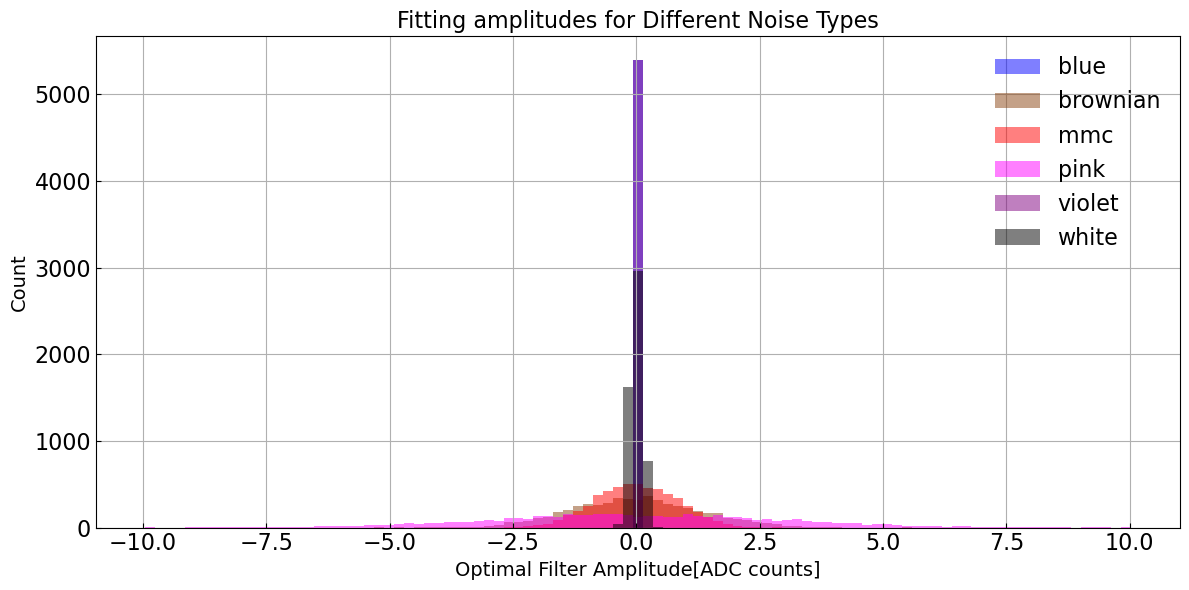

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from OptimumFilter import *
from trace_IO import *
import DELightStyle


# Assumptions
sampling_frequency = 3906250  # Hz
dt_ms = 1e3 / sampling_frequency  # Time step in ms
time_axis = np.arange(32768) * dt_ms  # Assuming traces have length 32768

# Load template and all PSDs
template = np.load("sub_ch_template.npy")
mmc_psd = np.load("../../templates/noise_psd_from_MMC.npy")
brownian_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_brownian.npy")
white_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_white.npy")
blue_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_blue.npy")
pink_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_pink.npy")
violet_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_from_violet.npy")

# Initialize filters
mmc_trigger = OptimumFilter(template, mmc_psd, sampling_frequency)
brownian_trigger = OptimumFilter(template, brownian_psd, sampling_frequency)
white_trigger = OptimumFilter(template, white_psd, sampling_frequency)
blue_trigger = OptimumFilter(template, blue_psd, sampling_frequency)
pink_trigger = OptimumFilter(template, pink_psd, sampling_frequency)
violet_trigger = OptimumFilter(template, violet_psd, sampling_frequency)

# Map labels to corresponding triggers
trigger_map = {
    'mmc': mmc_trigger,
    'brownian': brownian_trigger,
    'white': white_trigger,
    'blue': blue_trigger,
    'pink': pink_trigger,
    'violet': violet_trigger,
}

# Color mapping
color_map = {
    'white': 'black',
    'pink': 'magenta',
    'brownian': 'saddlebrown',
    'blue': 'blue',
    'violet': 'purple',
    'mmc': 'red',
}

# Process and collect amplitude statistics
def process_noise_file(filepath, label):
    print(f"\nProcessing {label} noise...")
    trigger = trigger_map[label]
    traces = load_traces_from_zstd(filepath, n_traces=100)
    amplitudes = []
    max_amp = -np.inf
    best_trace = None
    best_idx = -1
    best_ch = -1
    best_chisq = None

    for trace_idx, trace_set in enumerate(traces):
        for ch in range(54):
            amp, chisq = trigger.fit(trace_set[ch])
            amplitudes.append(amp)
    
    # Convert to numpy array for statistics
    amplitudes = np.array(amplitudes)
    
    # Calculate and print statistics
    mean_amp = np.mean(amplitudes)
    std_amp = np.std(amplitudes)
    min_amp = np.min(amplitudes)
    max_amp = np.max(amplitudes)
    
    print(f"  Mean amplitude: {mean_amp:.4f}")
    print(f"  Std amplitude:  {std_amp:.4f}")
    print(f"  Min amplitude:  {min_amp:.4f}")
    print(f"  Max amplitude:  {max_amp:.4f}")
    print(f"  Total samples:  {len(amplitudes)}")
    
    return amplitudes.tolist()  # Return as list for consistency with original code


# Define noise files
noise_dir = "/ceph/dwong/trigger_samples/noise_traces"
noise_files = [
    "blue_noise_traces.zst",
    "brownian_noise_traces.zst",
    "mmc_noise_traces.zst",
    "pink_noise_traces.zst",
    "violet_noise_traces.zst",
    "white_noise_traces.zst",
]

# Collect amplitudes for all noise types
all_amplitudes = {}

print("=" * 60)
print("AMPLITUDE STATISTICS FOR DIFFERENT NOISE TYPES")
print("=" * 60)

for filename in noise_files:
    full_path = os.path.join(noise_dir, filename)
    label = filename.replace("_noise_traces.zst", "")
    amplitudes = process_noise_file(full_path, label)
    all_amplitudes[label] = amplitudes

print("\n" + "=" * 60)
print("SUMMARY TABLE")
print("=" * 60)
print(f"{'Noise Type':<12} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
print("-" * 60)

for label, amps in all_amplitudes.items():
    amps_array = np.array(amps)
    print(f"{label:<12} {np.mean(amps_array):<10.4f} {np.std(amps_array):<10.4f} "
          f"{np.min(amps_array):<10.4f} {np.max(amps_array):<10.4f}")

# Plot histogram
plt.figure(figsize=(12, 6))
all_amps_flat = np.concatenate(list(all_amplitudes.values()))
bins = np.linspace(np.min(all_amps_flat), np.max(all_amps_flat), 100)

for label, amps in all_amplitudes.items():
    plt.hist(amps, bins=bins, alpha=0.5, label=label, color=color_map.get(label, 'gray'))

plt.title("Fitting amplitudes for Different Noise Types", fontsize=16)
plt.xlabel("Optimal Filter Amplitude[ADC counts]", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

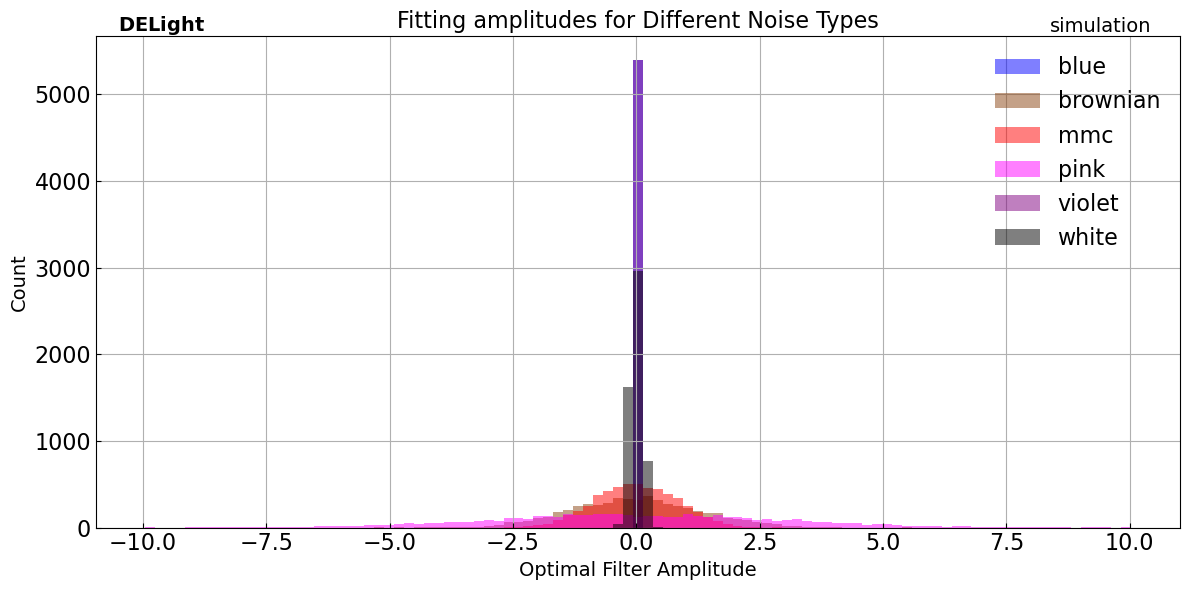

In [2]:
import DELightStyle
# Plot histogram
fig, ax = plt.subplots(figsize=(12, 6))
all_amps_flat = np.concatenate(list(all_amplitudes.values()))
bins = np.linspace(np.min(all_amps_flat), np.max(all_amps_flat), 100)
for label, amps in all_amplitudes.items():
    ax.hist(amps, bins=bins, alpha=0.5, label=label, color=color_map.get(label, 'gray'))

ax.set_title("Fitting amplitudes for Different Noise Types", fontsize=16)
ax.set_xlabel("Optimal Filter Amplitude", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.legend()
ax.grid(True)

# Add DELightStyle elements
DELightStyle.display_text(ax, r'$\mathbf{DELight}$', x0=0.02, y0=1.045)
DELightStyle.display_text(ax, "simulation", x0=0.88, y0=1.04)

plt.tight_layout()
plt.show()

In [12]:
import DELightStyle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np #needed for dummy datasets only
import os #needed for join path and filenames when saving plots
from matplotlib.gridspec import GridSpec
from TraceSimulator import TraceSimulator
import yaml

plt.rcParams['font.family'] = 'DejaVu Sans'  # Matplotlib's default font
def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('../../trigger_study/archive/config.yaml')
ts = TraceSimulator(config)

In [16]:
trace=ts.generate(E=500, x=-40, y=80, z=-1800, no_noise=False, type_recoil='NR', quantize=True, phonon_only=False)


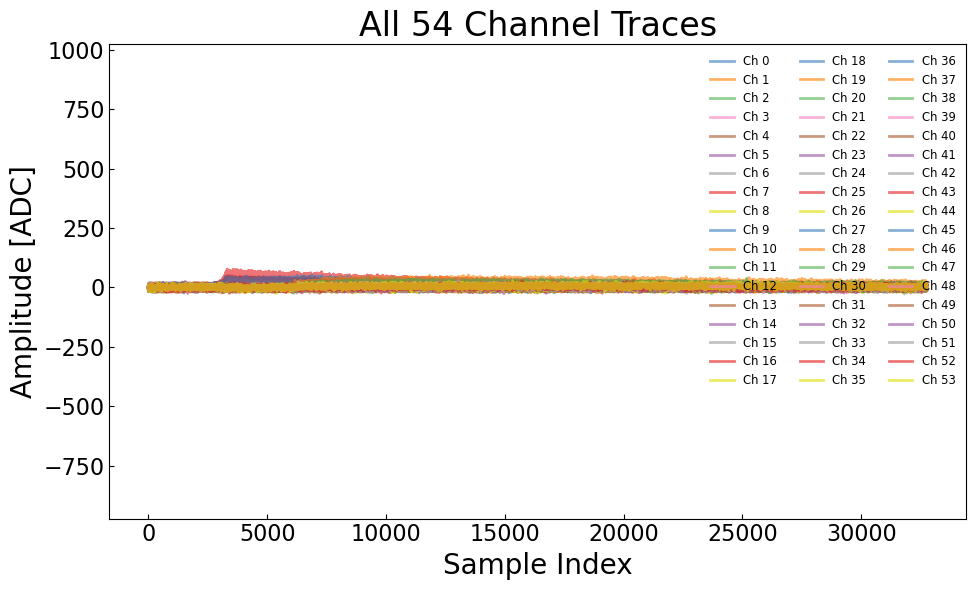

In [17]:
plt.figure(figsize=(10, 6))
for i in range(54):
    plt.plot(trace[0][i], alpha=0.6, label=f"Ch {i}")
plt.gca().set_aspect(10, adjustable='datalim')

plt.xlabel("Sample Index")
plt.ylabel("Amplitude [ADC]")
plt.title("All 54 Channel Traces")
plt.legend(ncol=3, fontsize='small', loc='upper right')  # adjust as needed
plt.tight_layout()
plt.show()

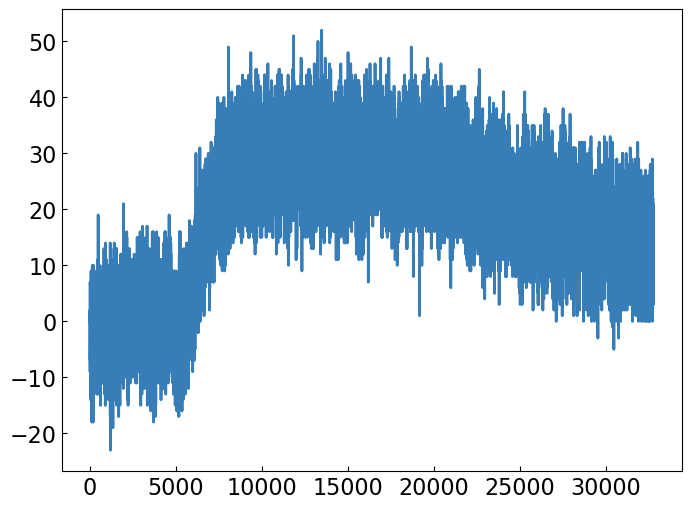

In [18]:
plt.plot(trace[0][46])

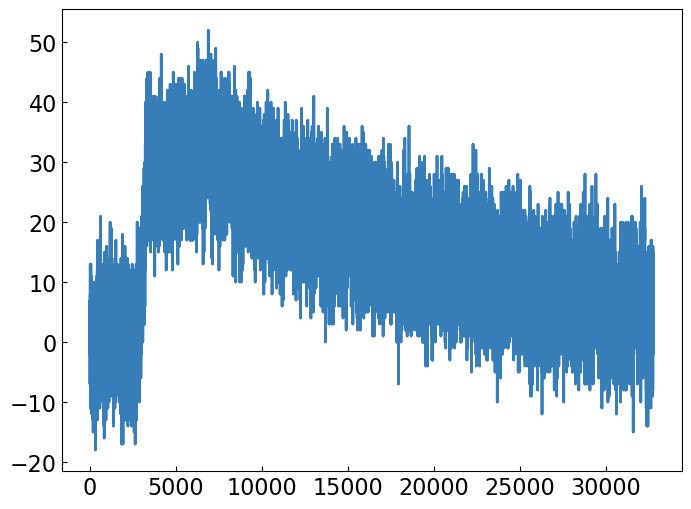

In [19]:
plt.plot(trace[0][45])